In [45]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from sklearn.metrics import roc_auc_score, roc_curve, auc
import joblib


%matplotlib inline

In [20]:
df=pd.read_csv("../input/water-quality/waterQuality1.csv")
df.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [21]:
df.shape

(7999, 21)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [23]:
missing_value = ['#NUM!', np.nan]
df=pd.read_csv("../input/water-quality/waterQuality1.csv", na_values = missing_value)
df.isnull().sum()
#df['ammonia']=df['ammonia'].fillna(df.groupby(['is_safe'])['ammonia'].transform('mean'))
#df.isna().sum()

aluminium      0
ammonia        3
arsenic        0
barium         0
cadmium        0
chloramine     0
chromium       0
copper         0
flouride       0
bacteria       0
viruses        0
lead           0
nitrates       0
nitrites       0
mercury        0
perchlorate    0
radium         0
selenium       0
silver         0
uranium        0
is_safe        3
dtype: int64

In [24]:
df.dropna( subset=['ammonia', 'is_safe'], axis=0, inplace=True)

In [25]:
df.isnull().sum()

aluminium      0
ammonia        0
arsenic        0
barium         0
cadmium        0
chloramine     0
chromium       0
copper         0
flouride       0
bacteria       0
viruses        0
lead           0
nitrates       0
nitrites       0
mercury        0
perchlorate    0
radium         0
selenium       0
silver         0
uranium        0
is_safe        0
dtype: int64

In [26]:
df.duplicated().sum()

0

In [27]:
df.describe()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,...,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000
mean,0.666396,14.278212,0.161477,1.567928,0.042803,2.177589,0.247300,0.805940,0.771646,0.319714,...,0.099431,9.819250,1.329846,0.005193,16.465266,2.920106,0.049684,0.147811,0.044672,0.114057
std,1.265323,8.878930,0.252632,1.216227,0.036049,2.567210,0.270663,0.653595,0.435423,0.329497,...,0.058169,5.541977,0.573271,0.002967,17.688827,2.322805,0.028773,0.143569,0.026906,0.317900
min,0.000000,-0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,6.577500,0.030000,0.560000,0.008000,0.100000,0.050000,0.090000,0.407500,0.000000,...,0.048000,5.000000,1.000000,0.003000,2.170000,0.820000,0.020000,0.040000,0.020000,0.000000
50%,0.070000,14.130000,0.050000,1.190000,0.040000,0.530000,0.090000,0.750000,0.770000,0.220000,...,0.102000,9.930000,1.420000,0.005000,7.745000,2.410000,0.050000,0.080000,0.050000,0.000000
75%,0.280000,22.132500,0.100000,2.482500,0.070000,4.240000,0.440000,1.390000,1.160000,0.610000,...,0.151000,14.610000,1.760000,0.008000,29.487500,4.670000,0.070000,0.240000,0.070000,0.000000
max,5.050000,29.840000,1.050000,4.940000,0.130000,8.680000,0.900000,2.000000,1.500000,1.000000,...,0.200000,19.830000,2.930000,0.010000,60.010000,7.990000,0.100000,0.500000,0.090000,1.000000


In [28]:
df.corr()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
aluminium,1.000000,0.067369,0.225725,0.294091,-0.099902,0.369221,0.353134,0.168569,-0.009877,-0.078324,...,0.020957,-0.003851,0.237439,-0.003129,0.362986,0.243396,-0.003651,0.334923,0.014723,0.333974
ammonia,0.067369,1.000000,0.046783,0.070099,-0.006422,0.104775,0.124782,0.015953,-0.028221,0.063603,...,-0.037065,0.006483,-0.063309,0.020884,0.090928,0.050401,0.029897,0.075547,0.014635,-0.022919
arsenic,0.225725,0.046783,1.000000,0.362925,0.334782,0.356509,0.312421,-0.036488,0.003731,0.035642,...,-0.087669,0.027533,0.305113,-0.015288,0.332228,0.218328,-0.006993,0.307794,0.001469,-0.123362
barium,0.294091,0.070099,0.362925,1.000000,-0.037901,0.446869,0.415937,0.065277,-0.018637,0.101304,...,-0.042829,-0.011423,0.312783,0.006165,0.462207,0.286890,0.035222,0.431542,-0.002541,0.090858
cadmium,-0.099902,-0.006422,0.334782,-0.037901,1.000000,-0.144366,-0.157716,-0.109252,0.005005,-0.092133,...,-0.035313,0.020232,-0.015829,-0.016169,-0.149269,-0.098936,0.009933,-0.155441,-0.005911,-0.256034
chloramine,0.369221,0.104775,0.356509,0.446869,-0.144366,1.000000,0.555846,0.118975,0.004254,0.154443,...,-0.030241,-0.001619,0.379916,-0.021198,0.588683,0.389119,0.011435,0.522372,-0.007648,0.186704
chromium,0.353134,0.124782,0.312421,0.415937,-0.157716,0.555846,1.000000,0.113003,-0.002424,0.141937,...,-0.050254,-0.012843,0.335940,-0.022541,0.524432,0.315484,0.030598,0.510705,-0.005472,0.182306
copper,0.168569,0.015953,-0.036488,0.065277,-0.109252,0.118975,0.113003,1.000000,0.011647,0.149271,...,0.121762,0.002259,0.162092,0.017785,0.104527,0.026534,-0.003356,0.089241,0.006802,0.029498
flouride,-0.009877,-0.028221,0.003731,-0.018637,0.005005,0.004254,-0.002424,0.011647,1.000000,0.013984,...,0.012146,-0.008245,-0.016591,-0.004263,-0.016352,0.007683,0.022726,0.014446,0.016849,0.006550
bacteria,-0.078324,0.063603,0.035642,0.101304,-0.092133,0.154443,0.141937,0.149271,0.013984,1.000000,...,-0.027179,-0.033993,0.246463,-0.004406,0.147526,0.099080,-0.006779,0.148199,0.045077,-0.022077


In [29]:
df['is_safe'].value_counts()

0.0    7084
1.0     912
Name: is_safe, dtype: int64

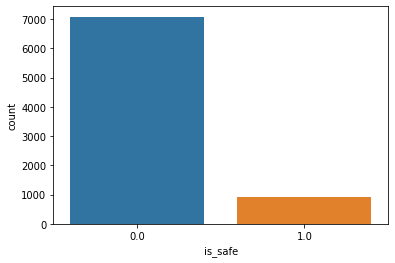

In [30]:
sns.countplot(df['is_safe'])
plt.show()

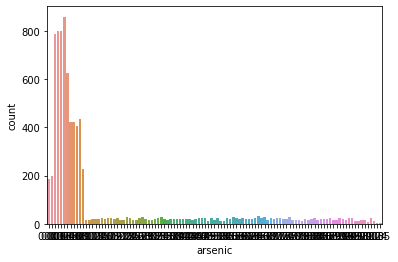

In [31]:
sns.countplot(df['arsenic'])
plt.show()

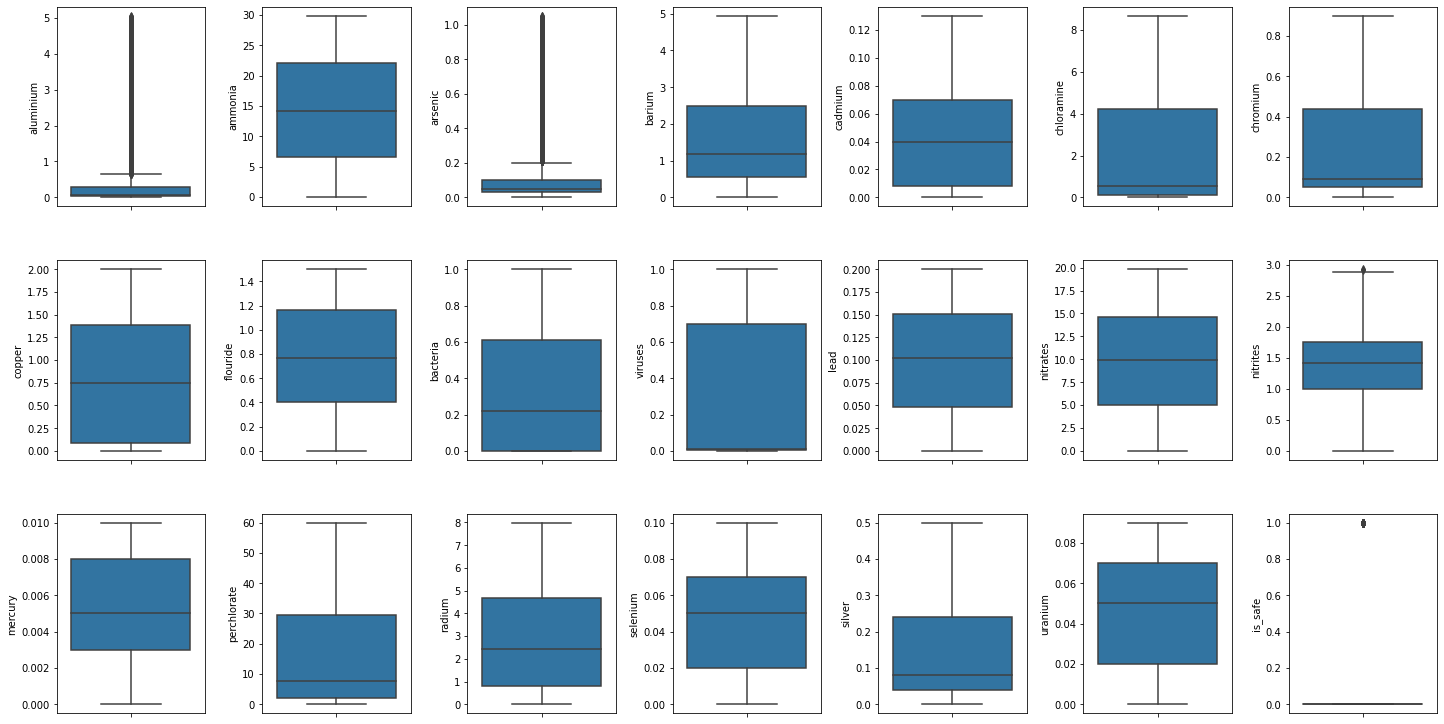

In [32]:
#box plot
fig, ax = plt.subplots(ncols=7, nrows=3, figsize=(20,10))
count = 0
ax = ax.flatten()
for i, value in df.items():
     sns.boxplot(y = i, data=df, ax=ax[count])
     count += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)      

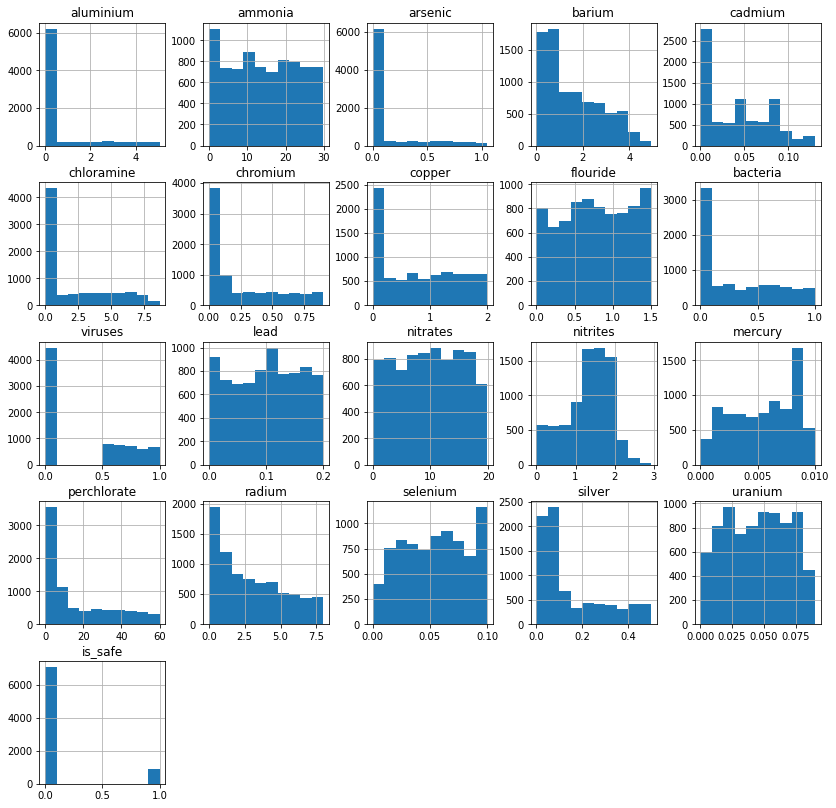

In [33]:
#distribution of the data
df.hist(figsize=(14, 14))
plt.show()

In [34]:
#coorelation matrix

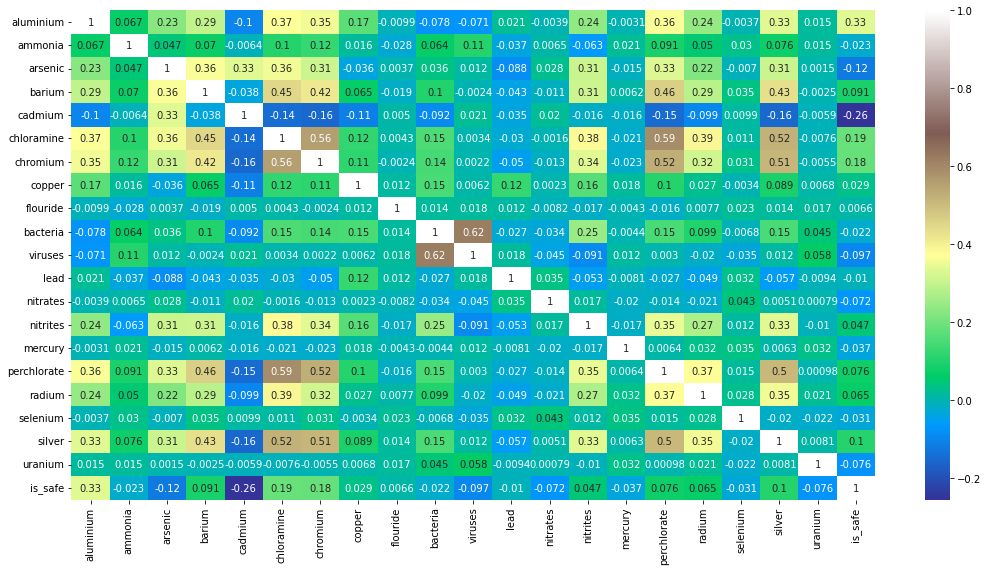

In [35]:
plt.figure(figsize=(18, 9))
sns.heatmap(df.corr(), annot=True, cmap='terrain')
plt.show()

In [37]:

# Split the data into features (X) and target (y)
x = df.drop("is_safe", axis=1)
y = df["is_safe"]

# Split the data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 24)

In [38]:
# Normalize the features
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [39]:
# the NearMiss algorithm is an under-sampling technique used for handling imbalanced datasets.
# It aims to balance the class distribution by selecting a subset of samples 
# from the majority class that is close to the samples in the minority class.
nm = NearMiss()
x_resample, y_resample = nm.fit_resample(x, y)

from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_resample)))

Original dataset shape Counter({0.0: 7084, 1.0: 912})
Resampled dataset shape Counter({0.0: 912, 1.0: 912})


In [40]:
xtrain.shape

(6396, 20)

In [41]:
xtest.shape

(1600, 20)

In [42]:
ytest.shape

(1600,)

In [46]:
# Create and train the LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(xtrain, ytrain)

# Define the classify function
def classify(model, xtest, ytest):
    predict = model.predict(xtest)
    report = classification_report(ytest, predict)
    return report

# Evaluate the LGBMClassifier using the classify function
classification_report = classify(lgbm, xtest, ytest)
print(classification_report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1419
         1.0       0.93      0.86      0.89       181

    accuracy                           0.98      1600
   macro avg       0.96      0.92      0.94      1600
weighted avg       0.98      0.98      0.98      1600



LGBM Classifier Confusion Matrix


<AxesSubplot:>

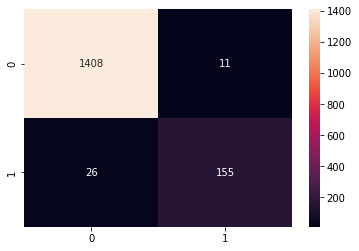

In [47]:
print('LGBM Classifier Confusion Matrix')
y_pred = lgbm.predict(xtest)

cm = confusion_matrix(ytest, y_pred)
sns.heatmap(cm, annot=True, fmt = 'g')

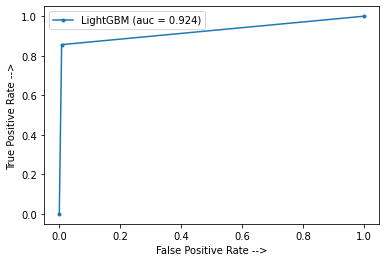

In [48]:
# roc curve
#lightgbm
y_pred_lgbm = lgbm.predict(xtest).ravel()
lgbm_fpr, lgbm_tpr, threshold = roc_curve(ytest, y_pred_lgbm)
auc_lgbm = auc(lgbm_fpr, lgbm_tpr)
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LightGBM (auc = %0.3f)' % auc_lgbm)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [49]:
# save lgbm model
joblib.dump(lgbm, 'lgbm_model.pkl')


['lgbm_model.pkl']

In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Normalize the features
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Create a DNN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(xtrain.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(xtrain, ytrain, epochs=50, batch_size=32, validation_data=(xtest, ytest))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(xtest, ytest)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/50
200/200 [==============================] - 2s 6ms/step - loss: 0.2741 - accuracy: 0.8946 - val_loss: 0.2087 - val_accuracy: 0.9231
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1997 - accuracy: 0.9229 - val_loss: 0.1869 - val_accuracy: 0.9300
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1729 - accuracy: 0.9339 - val_loss: 0.1739 - val_accuracy: 0.9388
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1489 - accuracy: 0.9425 - val_loss: 0.1583 - val_accuracy: 0.9419
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1329 - accuracy: 0.9492 - val_loss: 0.1413 - val_accuracy: 0.9513
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1193 - accuracy: 0.9559 - val_loss: 0.1361 - val_accuracy: 0.9525
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1099 - accuracy: 0.9598 - val_loss: 0.1336 - val_accuracy: 0.9506
Epoch 

In [51]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r_squared = r2_score(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)
rmse = mean_squared_error(ytest, y_pred, squared=False)
mse = mean_squared_error(ytest, y_pred)

print(f'Test accuracy: {test_accuracy}')
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)

Test accuracy: 0.9456250071525574
R-squared: 0.7695054100039325
Mean Absolute Error: 0.023125
Root Mean Squared Error: 0.15206906325745548
Mean Squared Error: 0.023125


In [54]:
# Save the trained DNN model in HDF5 format
model.save("Last94Quality_dnn_model2.h5")

In [56]:

# Predict the test data
y_pred = (model.predict(xtest) > 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(ytest, y_pred)
print("Confusion Matrix:\n", confusion)

Confusion Matrix:
 [[1371   48]
 [  39  142]]


In [61]:
# Assuming you have already trained your DNN model and predicted the test data
y_pred = (model.predict(xtest) > 0.5).astype(int)

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(ytest, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1419
         1.0       0.75      0.78      0.77       181

    accuracy                           0.95      1600
   macro avg       0.86      0.88      0.87      1600
weighted avg       0.95      0.95      0.95      1600

